In [1]:
import pandas as pd
import numpy as np
import ast
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
pd.set_option('precision', 3)
sns.set_style("whitegrid")
sns.set(font_scale = 1.2)
mdata = pd.read_csv("C:\\Users\\ASUS\\Desktop\\Data Mining Project\\ted-talks\\ted_main.csv")
tdata = pd.read_csv("C:\\Users\\ASUS\\Desktop\\Data Mining Project\\ted-talks\\transcripts.csv")

## Data Preprocessing
### published date

In [3]:
mdata['published_date'] = mdata['published_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%d-%m-%Y'))
mdata['length'] = mdata['published_date'].apply(lambda x: (2018 - int(x.split('-')[2])) * 12 + 12 - int(x.split('-')[1]))

### related video

In [4]:
mdata['related_talks'] = mdata['related_talks'].apply(lambda x: ast.literal_eval(x))

In [5]:
for i in range(len(mdata)):
    sumv = 0
    for j in mdata.loc[i, 'related_talks']:
        sumv += j['viewed_count']
    mdata.loc[i, 'related_views'] = int(sumv / len(mdata.loc[i, 'related_talks']))

### event

In [6]:
# For 6 event classes, creating 5 dummy attributes except 'Other event'
#data['Other event'] = 0 
mdata['TEDannual'] = 0
mdata['TEDx'] = 0
mdata['TEDGlobal'] = 0
mdata['TEDWomen'] = 0
mdata['TEDSalon'] = 0
mdata['TEDNYC'] = 0
for i in range(len(mdata)):
    if 'TED20' in mdata.loc[i, 'event'] or 'TED19' in mdata.loc[i, 'event']:
        mdata.loc[i, 'TEDannual'] = 1
    elif 'TEDx' in mdata.loc[i, 'event']:
        mdata.loc[i, 'TEDx'] = 1
    elif 'TEDGlobal' in mdata.loc[i, 'event']:
        mdata.loc[i, 'TEDGlobal'] = 1
    elif 'TEDWomen' in mdata.loc[i, 'event']:
        mdata.loc[i, 'TEDWomen'] = 1
    elif 'TEDSalon' in mdata.loc[i, 'event']:
        mdata.loc[i, 'TEDSalon'] = 1
    elif 'TEDNYC' in mdata.loc[i]['event']:
        mdata.loc[i, 'TEDNYC'] = 1
    else:
        pass

### rating label

In [7]:
mdata['ratings'] = mdata['ratings'].apply(lambda x: ast.literal_eval(x))

In [8]:
rating_class = {'Confusing':'very bad', 'Unconvincing': 'very bad', 'Longwinded':'bad', 'Obnoxious':'bad',
                'OK':'moderate', 'Informative':'moderate', 'Funny':'good', 'Persuasive':'good', 'Ingenious':'good', 'Jaw-dropping':'good',
                'Beautiful':'very good', 'Courageous':'very good', 'Fascinating':'very good', 'Inspiring':'very good'}

for i in range(len(mdata)):
    sumc = 0
    temp = pd.Series(0, index = ['very bad', 'bad', 'moderate', 'good', 'very good'])
    for j, rating in enumerate(mdata.loc[i, 'ratings']):
        temp[rating_class[rating['name']]] += rating['count']
        sumc += rating['count']
    temp = temp / sumc
    mdata.loc[i, 'very bad'] = temp['very bad']
    mdata.loc[i, 'bad'] = temp['bad']
    mdata.loc[i, 'moderate'] = temp['moderate']
    mdata.loc[i, 'good'] = temp['good']
    mdata.loc[i, 'very good'] = temp['very good']

### topic (extracted from transcripts)

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df = 0.05, max_df = 0.3, stop_words='english')
tfidf = vectorizer.fit_transform(tdata['transcript'])

In [10]:
no_topics = 15
no_top_words = 5
nmf = NMF(n_components=no_topics, random_state=0, l1_ratio=0.5, alpha=0.1)
W = nmf.fit_transform(tfidf) # W_jk is the probabilistic correlation between document_j and topic_k

H = []
for topic_id, topic in enumerate(nmf.components_):
    temp = pd.Series()
    for index in topic.argsort()[:-no_top_words - 1:-1]:
        temp[vectorizer.get_feature_names()[index]] = topic[index]
    H.append(temp)

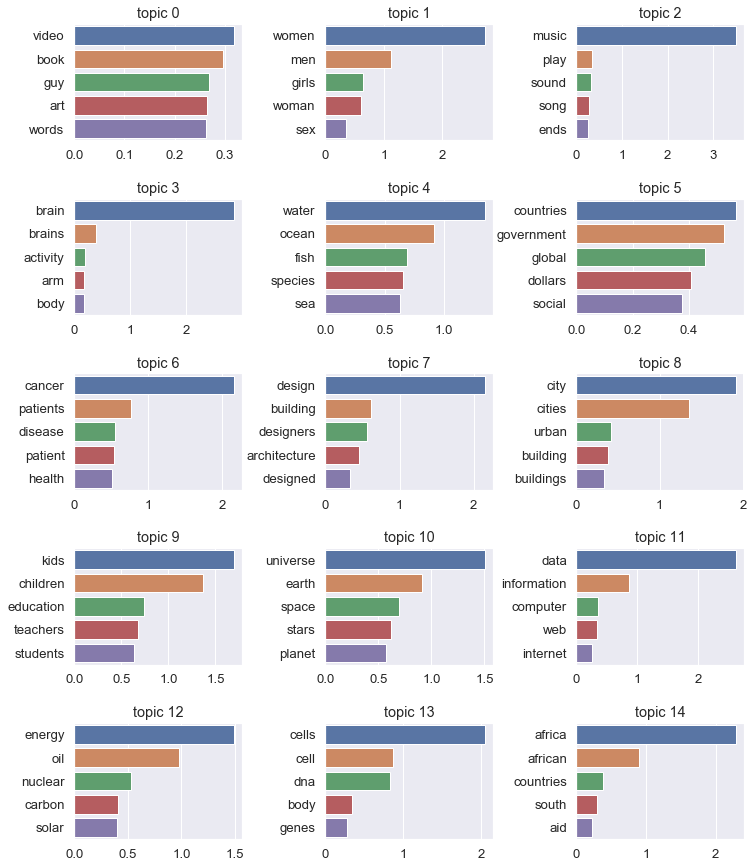

In [11]:
fig, ax = plt.subplots(figsize=(12, 15), ncols=3, nrows=5)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(no_topics):
    sns.barplot(x = H[i].values, y = H[i].index, ax = ax[int(i/3)][i%3]).set_title('topic ' + str(i))
plt.show()

In [12]:
(rows, cols) = W.shape
for i in range(rows):
    for j in range(cols):
        tdata.loc[i, 'topic '+ str(j)] = W[i, j]
data = pd.merge(left = mdata ,right = tdata, how = 'right', on = 'url')

In [13]:
data.to_csv("C:\\Users\\ASUS\\Desktop\\data.csv")

## Predicting Views & Comments

In [14]:
X = data[['languages', 'length', 'duration', 'related_views', 'TEDannual', 'TEDx', 'TEDGlobal', 'TEDWomen', 'TEDSalon', 'TEDNYC',
          'very bad', 'bad', 'moderate', 'good', 'very good', 'topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 
          'topic 6', 'topic 7', 'topic 8', 'topic 9', 'topic 10',
          'topic 11', 'topic 12', 'topic 13', 'topic 14']]
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)
y1 = data['views'].apply(lambda x: int(x / 100))
y2 = data['comments'].apply(lambda x: int(x / 100))

d:\my software\python 3.6.5\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\my software\python 3.6.5\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


### Ridge Regressor

In [15]:
ridge_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv = 10, scoring = 'neg_mean_squared_error')
lasso_reg = LassoCV(cv = 10, random_state = 0)
ridge_reg.fit(X, y1)
score1 = ridge_reg.score(X, y1)
attr_coef = pd.Series(ridge_reg.coef_, index = X.columns).sort_values(ascending = False).apply(np.log10)
ridge_reg.fit(X, y2)
score2 = ridge_reg.score(X, y2)
print('views MSE:', score1, ' ', 'comments MSE:', score2)

d:\my software\python 3.6.5\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.893074e-19
  overwrite_a=True).T
d:\my software\python 3.6.5\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.143858e-19
  overwrite_a=True).T
d:\my software\python 3.6.5\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.846970e-19
  overwrite_a=True).T
d:\my software\python 3.6.5\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.818554e-19
  overwrite_a=True

views MSE: 0.29226757194742226   comments MSE: 0.26646810155777056


d:\my software\python 3.6.5\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
d:\my software\python 3.6.5\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.629107e-17
  overwrite_a=True).T


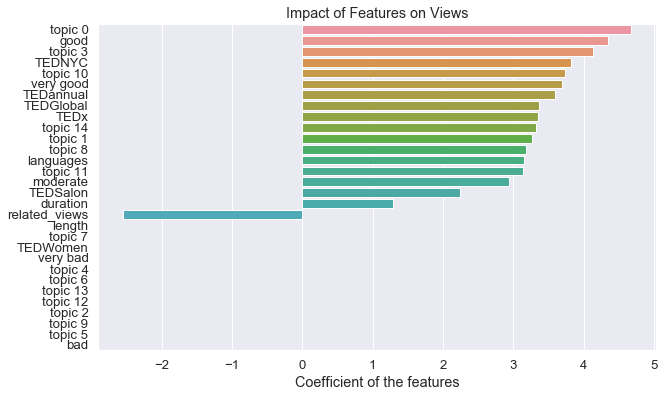

In [16]:
plt.figure(figsize = (10, 6))
plt.xlabel('Coefficient of the features')
plt.title('Impact of Features on Views: Ridge Regression')
sns.barplot(x= attr_coef.values, y = attr_coef.index)
plt.show()

### Lasso Regression

In [17]:
lasso_reg = LassoCV(cv=5, random_state=0)
lasso_reg.fit(X, y1)
score1 = lasso_reg.score(X, y1)
attr_coef = pd.Series(lasso_reg.coef_, index = X.columns).sort_values(ascending = False)
lasso_reg.fit(X, y2)
score2 = lasso_reg.score(X, y2)
print('views MSE:', score1, ' ', 'comments MSE:', score2)

views MSE: 0.09183221674887376   comments MSE: 0.02904658956002826


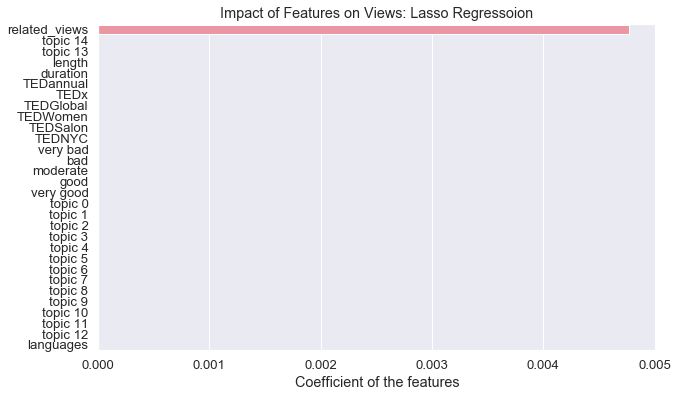

In [18]:
plt.figure(figsize = (10, 6))
plt.xlabel('Coefficient of the features')
plt.title('Impact of Features on Views: Lasso Regressoion')
sns.barplot(x= attr_coef.values, y = attr_coef.index)
plt.show()

### ElasticNet

In [19]:
ec_reg = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=50000, cv=10, random_state=0)
ec_reg.fit(X, y1)
score1 = ec_reg.score(X, y1)
attr_coef = pd.Series(ec_reg.coef_, index = X.columns).sort_values(ascending = False).apply(np.log10)
ec_reg.fit(X, y2)
score2 = ec_reg.score(X, y2)
print('views MSE:', score1, ' ', 'comments MSE:', score2)

views MSE: 0.29278870420563907   comments MSE: 0.26420880114545653


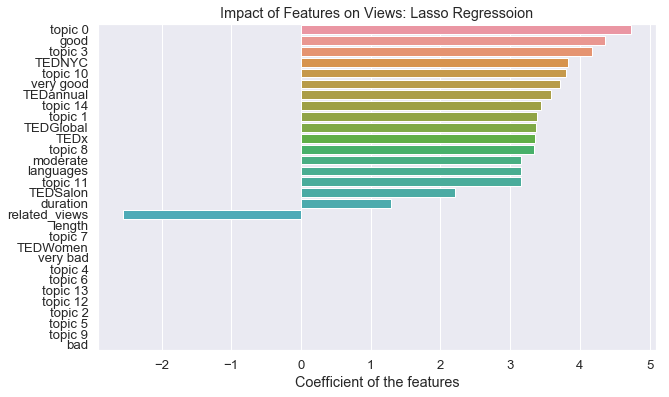

In [21]:
plt.figure(figsize = (10, 6))
plt.xlabel('Coefficient of the features')
plt.title('Impact of Features on Views: Elastic Net')
sns.barplot(x= attr_coef.values, y = attr_coef.index)
plt.show()